In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
MASTER = Path("../data/processed/master_teams_2000_2019.csv")
TAB_OUT = Path("../data/processed")
FIG_OUT = Path("../plots/final_version")
TAB_OUT.mkdir(parents=True, exist_ok=True)
FIG_OUT.mkdir(parents=True, exist_ok=True)
LATEX_OUT = Path("../latex/tables/final_version")
LATEX_OUT.mkdir(parents=True, exist_ok=True)

In [3]:
df = pd.read_csv(MASTER, parse_dates=["season_date"])

In [4]:
BEST_FORMULA = "W ~ RunDiff + ERA + HR"
BASELINE_FORMULAS = {
    "RunDiff (lineal)": "W ~ RunDiff",
    "ERA (lineal)": "W ~ ERA",
    "HR (lineal)": "W ~ HR",
}

In [5]:
train_mask = (df["yearID"] >= 2000) & (df["yearID"] <= 2016)
test_mask = (df["yearID"] >= 2017) & (df["yearID"] <= 2019)

In [6]:
df_train = df.loc[train_mask].copy()
df_test = df.loc[test_mask].copy()

In [7]:
print(df_train["yearID"].min(), df_train["yearID"].max(), len(df_train))
print(df_test["yearID"].min(), df_test["yearID"].max(), len(df_test))

2000 2016 510
2017 2019 90


In [8]:
best_mod = smf.ols(BEST_FORMULA, data=df_train).fit()
print(best_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                      W   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     1192.
Date:                Wed, 01 Oct 2025   Prob (F-statistic):          6.74e-229
Time:                        01:17:15   Log-Likelihood:                -1430.4
No. Observations:                 510   AIC:                             2869.
Df Residuals:                     506   BIC:                             2886.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.1507      1.845     46.693      0.0

In [9]:
pred_train = best_mod.get_prediction(df_train)
pred_train_df = pred_train.summary_frame(alpha=0.05)

In [10]:
df_train_pred = df_train.copy()
df_train_pred["yhat"] = pred_train_df["mean"].values
df_train_pred["mean_ci_low"] = pred_train_df["mean_ci_lower"].values
df_train_pred["mean_ci_high"] = pred_train_df["mean_ci_upper"].values
df_train_pred["pred_ci_low"] = pred_train_df["obs_ci_lower"].values
df_train_pred["pred_ci_high"] = pred_train_df["obs_ci_upper"].values

In [11]:
pred_test = best_mod.get_prediction(df_test)
pred_test_df = pred_test.summary_frame(alpha=0.05)
df_test_pred = df_test.copy()
df_test_pred["yhat"] = pred_test_df["mean"].values
df_test_pred["mean_ci_low"] = pred_test_df["mean_ci_lower"].values
df_test_pred["mean_ci_high"] = pred_test_df["mean_ci_upper"].values
df_test_pred["pred_ci_low"] = pred_test_df["obs_ci_lower"].values
df_test_pred["pred_ci_high"] = pred_test_df["obs_ci_upper"].values

In [12]:
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

In [13]:
mse_tr, rmse_tr, mae_tr = metrics(df_train_pred["W"], df_train_pred["yhat"])
mse_te, rmse_te, mae_te = metrics(df_test_pred["W"], df_test_pred["yhat"])

In [14]:
eval_rows = [
    {
        "Modelo": "Best: " + BEST_FORMULA,
        "Split": "Train (2000–2016)",
        "MSE": mse_tr,
        "RMSE": rmse_tr,
        "MAE": mae_tr,
        "N": len(df_train_pred),
    },
    {
        "Modelo": "Best: " + BEST_FORMULA,
        "Split": "Test (2017–2019)",
        "MSE": mse_te,
        "RMSE": rmse_te,
        "MAE": mae_te,
        "N": len(df_test_pred),
    },
]

In [15]:
for name, fml in BASELINE_FORMULAS.items():
    mod = smf.ols(fml, data=df_train).fit()
    yhat_tr = mod.predict(df_train)
    yhat_te = mod.predict(df_test)
    mse_tr, rmse_tr, mae_tr = metrics(df_train["W"], yhat_tr)
    mse_te, rmse_te, mae_te = metrics(df_test["W"], yhat_te)
    eval_rows.append(
        {
            "Modelo": name,
            "Split": "Train (2000–2016)",
            "MSE": mse_tr,
            "RMSE": rmse_tr,
            "MAE": mae_tr,
            "N": len(df_train),
        }
    )
    eval_rows.append(
        {
            "Modelo": name,
            "Split": "Test (2017–2019)",
            "MSE": mse_te,
            "RMSE": rmse_te,
            "MAE": mae_te,
            "N": len(df_test),
        }
    )

In [16]:
eval_df = pd.DataFrame(eval_rows)
eval_df.to_csv(TAB_OUT / "forecast_eval_metrics.csv", index=False, float_format="%.6f")
print(eval_df)

                         Modelo              Split         MSE       RMSE  \
0  Best: W ~ RunDiff + ERA + HR  Train (2000–2016)   15.980332   3.997541   
1  Best: W ~ RunDiff + ERA + HR   Test (2017–2019)   15.721325   3.965013   
2              RunDiff (lineal)  Train (2000–2016)   16.419602   4.052111   
3              RunDiff (lineal)   Test (2017–2019)   15.570596   3.945959   
4                  ERA (lineal)  Train (2000–2016)   78.792363   8.876506   
5                  ERA (lineal)   Test (2017–2019)   83.491520   9.137369   
6                   HR (lineal)  Train (2000–2016)  109.491126  10.463801   
7                   HR (lineal)   Test (2017–2019)  165.823211  12.877236   

         MAE    N  
0   3.205330  510  
1   3.027468   90  
2   3.251917  510  
3   2.977856   90  
4   7.176658  510  
5   7.209467   90  
6   8.630158  510  
7  10.449960   90  


In [17]:
try:
    with open(LATEX_OUT / "forecast_eval_metrics.tex", "w") as f:
        f.write(
            eval_df.rename(
                columns={
                    "Modelo": "Modelo",
                    "Split": "Partición",
                    "MSE": "MSE",
                    "RMSE": "RMSE",
                    "MAE": "MAE",
                    "N": "N",
                }
            ).to_latex(
                index=False,
                float_format="%.3f",
                caption="Evaluación de pronóstico (train/test temporal)",
                label="tab:forecast_eval",
            )
        )
    print(f"Tabla LaTeX exportada: {LATEX_OUT / 'forecast_eval_metrics.tex'}")
except Exception as e:
    print("No se exportó LaTeX (opcional). Razón:", e)

Tabla LaTeX exportada: ../latex/tables/final_version/forecast_eval_metrics.tex


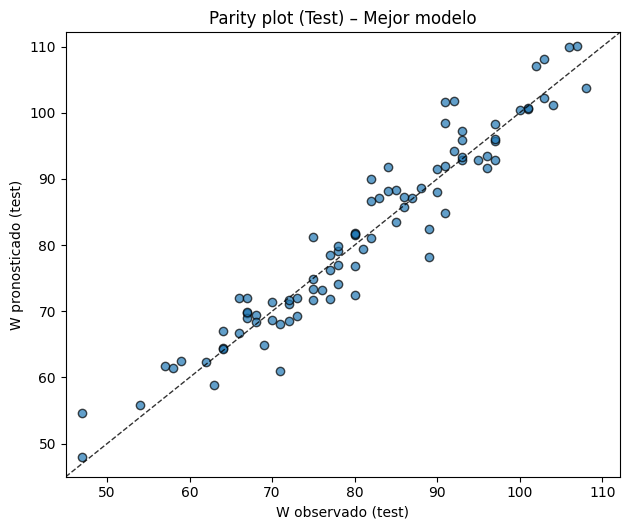

In [ ]:
plt.figure(figsize=(6.4, 5.4))
plt.scatter(df_test_pred["W"], df_test_pred["yhat"], alpha=0.7, edgecolor="black")
lims = [
    min(df_test_pred["W"].min(), df_test_pred["yhat"].min()) - 2,
    max(df_test_pred["W"].max(), df_test_pred["yhat"].max()) + 2,
]
plt.plot(lims, lims, "k--", lw=1, alpha=0.8)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("W observado (test)")
plt.ylabel("W pronosticado (test)")
plt.title("Parity plot (Test) – Mejor modelo")
plt.tight_layout()
plt.savefig(
    FIG_OUT / "forecast_parity_test_best.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close()

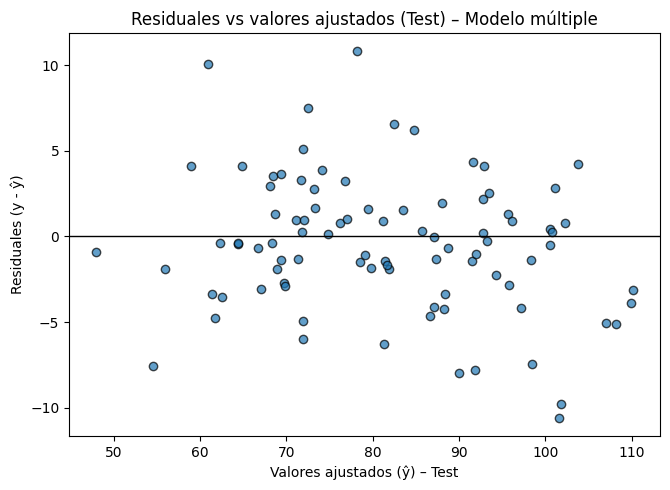

In [19]:
resid_test = df_test_pred["W"] - df_test_pred["yhat"]
plt.figure(figsize=(6.8, 5.0))
plt.scatter(df_test_pred["yhat"], resid_test, alpha=0.7, edgecolor="black")
plt.axhline(0.0, lw=1.0, color="black")
plt.xlabel("Valores ajustados (ŷ) – Test")
plt.ylabel("Residuales (y - ŷ)")
plt.title("Residuales vs valores ajustados (Test) – Modelo múltiple")
plt.tight_layout()
plt.savefig(
    FIG_OUT / "forecast_residuals_vs_fitted_test.png",
    dpi=150,
    bbox_inches="tight",
    transparent=True,
)
plt.show()
plt.close()

In [20]:
def forecast_new(best_fitted_model, new_rows):
    if isinstance(new_rows, pd.DataFrame):
        new = new_rows.copy()
    else:
        new = pd.DataFrame(new_rows)
    required = {"RunDiff", "ERA", "HR"}
    missing = required - set(new.columns)
    if missing:
        raise ValueError(f"Faltan columnas requeridas: {sorted(missing)}")
    pred = best_fitted_model.get_prediction(new)
    sf = pred.summary_frame(alpha=0.05)
    out = new.reset_index(drop=True).copy()
    out["yhat"] = sf["mean"].values
    out["mean_ci_low"] = sf["mean_ci_lower"].values
    out["mean_ci_high"] = sf["mean_ci_upper"].values
    out["pred_ci_low"] = sf["obs_ci_lower"].values
    out["pred_ci_high"] = sf["obs_ci_upper"].values
    return out

In [21]:
ejemplo = forecast_new(
    best_mod,
    new_rows=[
        {"RunDiff": -150, "ERA": 5.0, "HR": 140},
        {"RunDiff": -50, "ERA": 4.3, "HR": 170},
        {"RunDiff": 0, "ERA": 4.0, "HR": 200},
        {"RunDiff": 50, "ERA": 3.8, "HR": 210},
        {"RunDiff": 150, "ERA": 3.5, "HR": 230},
        {"RunDiff": 250, "ERA": 3.2, "HR": 250},
    ],
)
print(ejemplo)
ejemplo.to_csv(TAB_OUT / "forecast_new_examples.csv", index=False)

   RunDiff  ERA   HR        yhat  mean_ci_low  mean_ci_high  pred_ci_low  \
0     -150  5.0  140   65.108217    64.390262     65.826171    57.190794   
1      -50  4.3  170   76.264253    75.831285     76.697221    68.367571   
2        0  4.0  200   82.024660    81.309088     82.740232    74.107453   
3       50  3.8  210   87.213990    86.409977     88.018002    79.288300   
4      150  3.5  230   97.395913    96.406008     98.385818    89.449213   
5      250  3.2  250  107.577837   106.333227    108.822446    99.595407   

   pred_ci_high  
0     73.025639  
1     84.160935  
2     89.941867  
3     95.139679  
4    105.342613  
5    115.560266  
